# Polygon trap defined from .gds layout

The following notebook presents initialization and simulation of a trap, defined as a Graphic Data System (GDS) file. *Sion* initializes the trap in *electrode.System* object, and returns the electrode coordinates for simulation with *sion.polygon_trap* function. It is useful to simulate complicated layouts, directly produced in GDS form.

In [72]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from mpl_toolkits.mplot3d import Axes3D
from electrode import (System, PolygonPixelElectrode, PointPixelElectrode, shaped)

import sion as sn


## Trap initialization

To initialize the trap, the name of GDS file (library) is provided. Then, the *electrode.System* object is returned. On the plot of the layout, each of the electrodes is labeled according to its order in coordinates and *s*. The list of coordinates of each electrodes is provided for simulation.

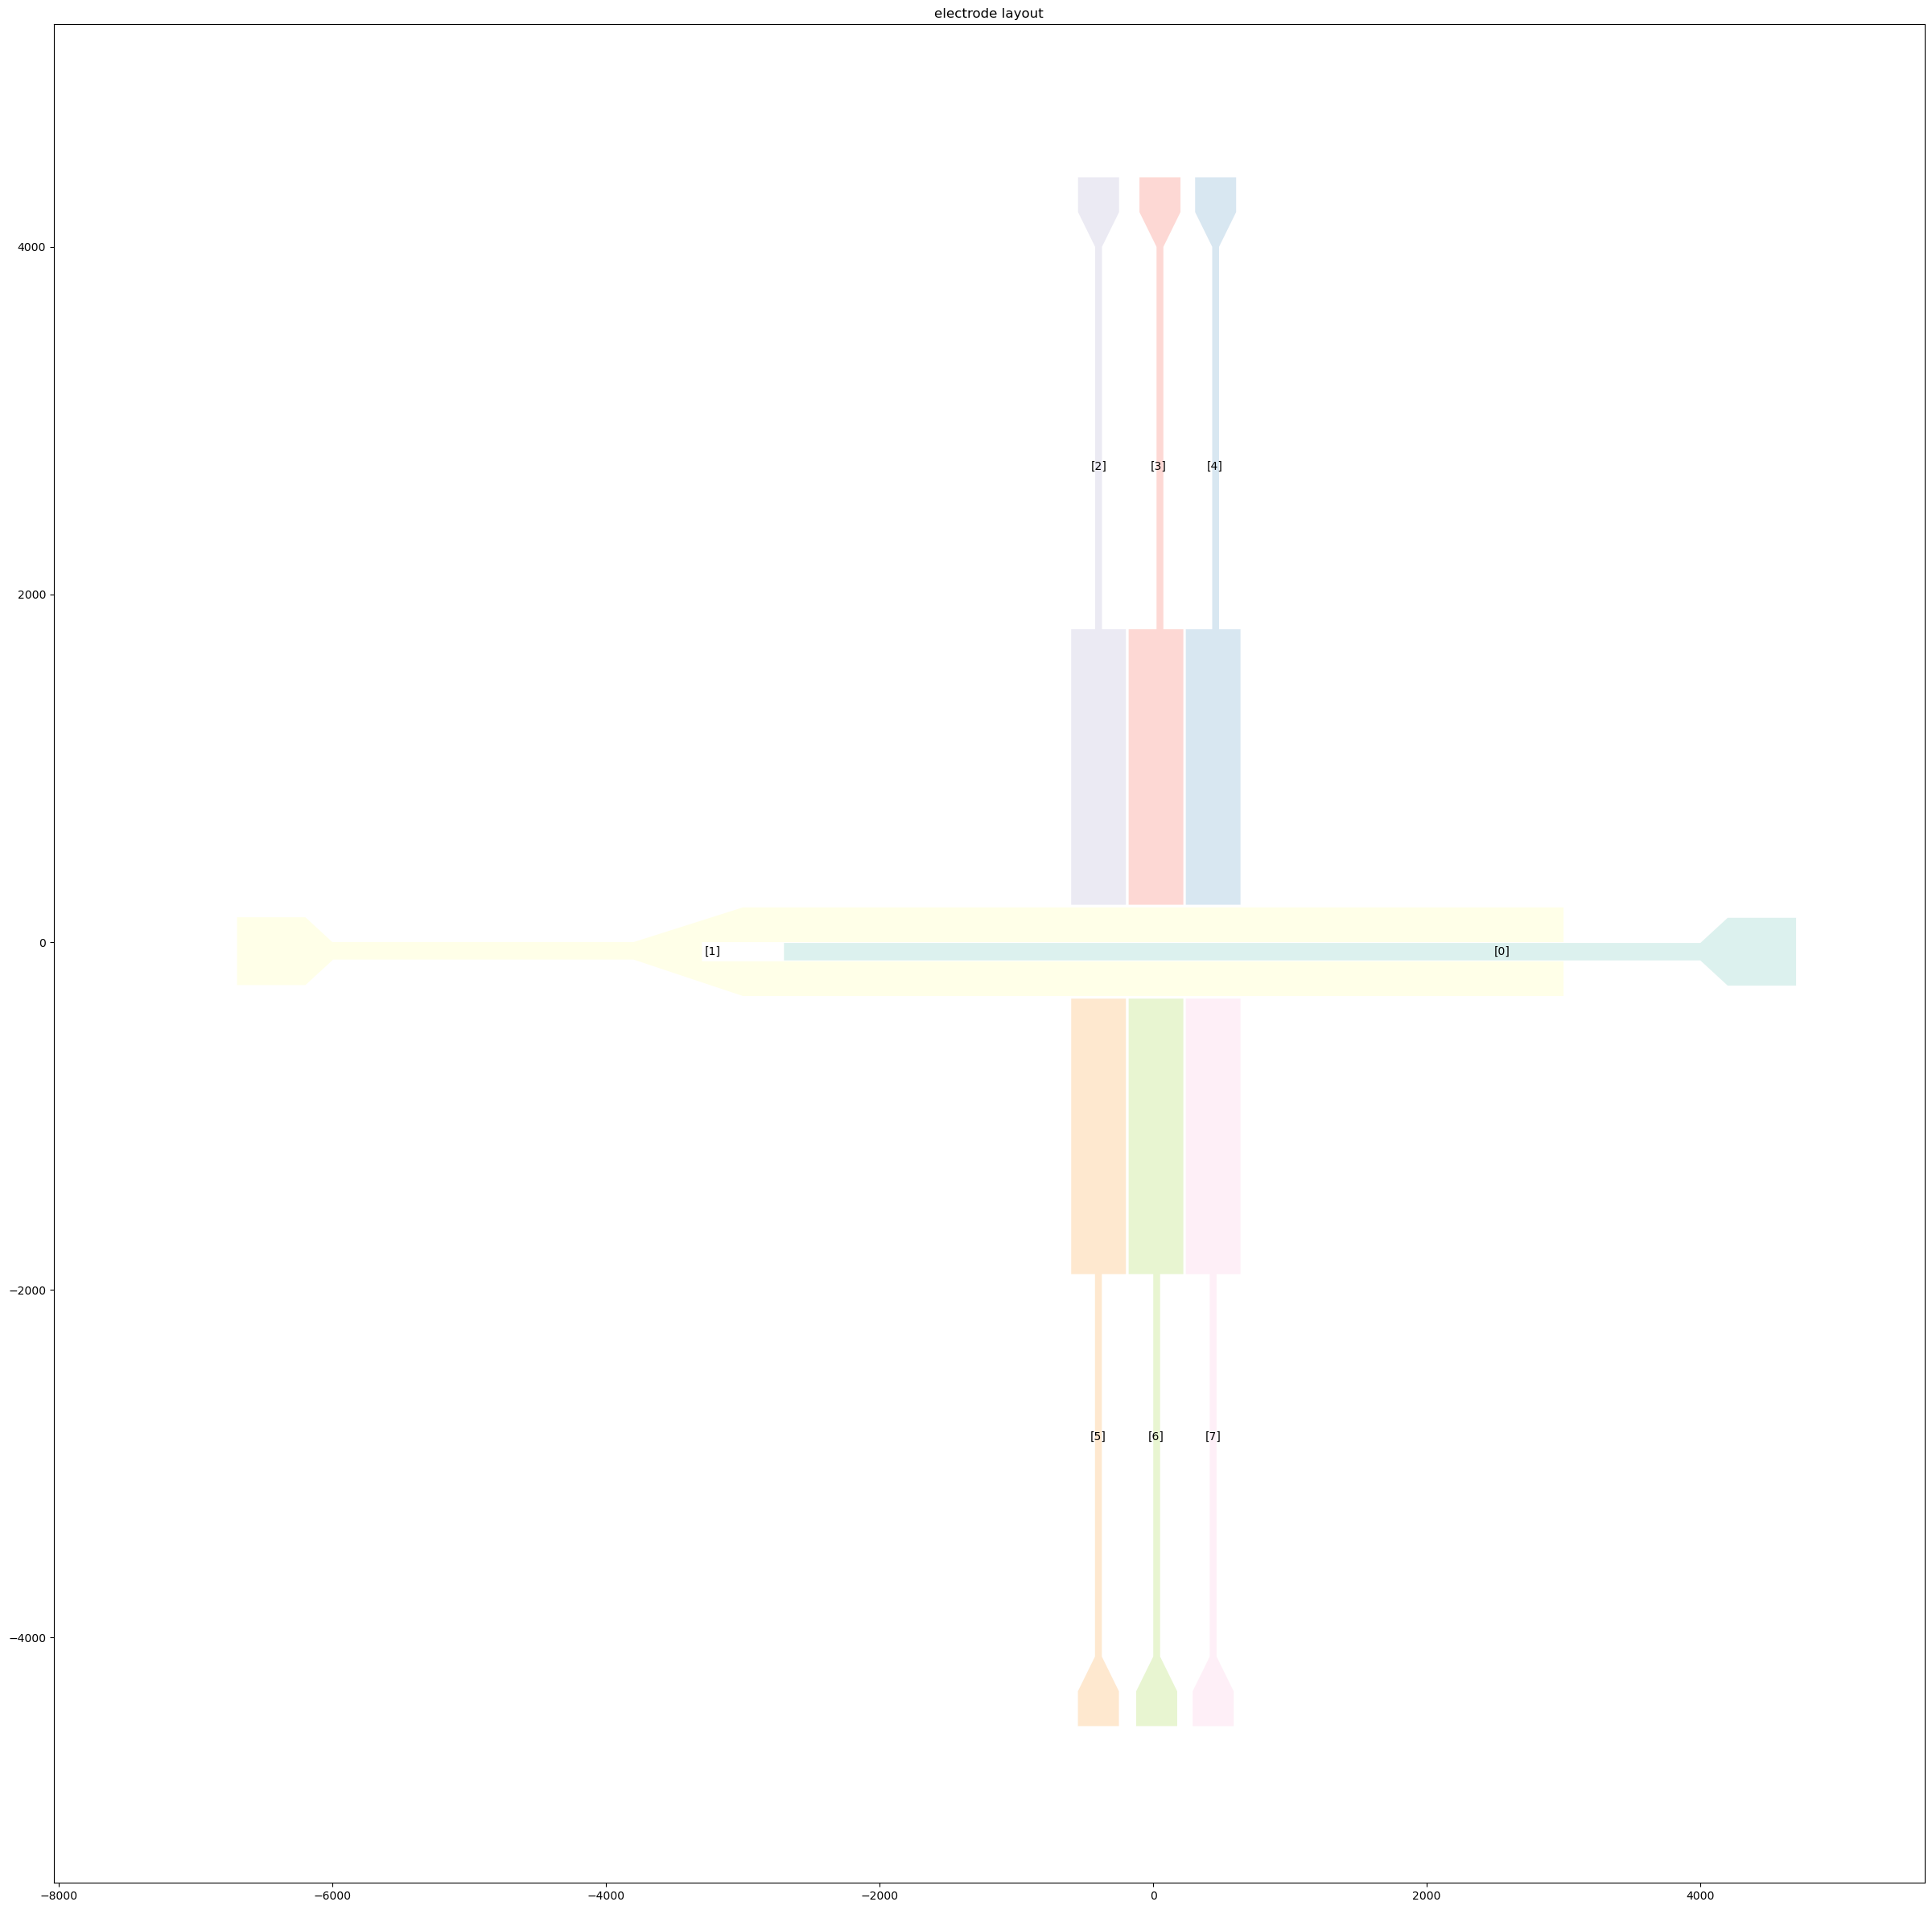

In [73]:
L = 1e-6 # µm length scale
s, full_electrode_list = sn.polygons_from_gds('test.GDS', need_plot = True, need_coordinates = True, L=L)

## Voltage initialization

With the help of the labels on the plot, each of the electrodes is assigned a voltage

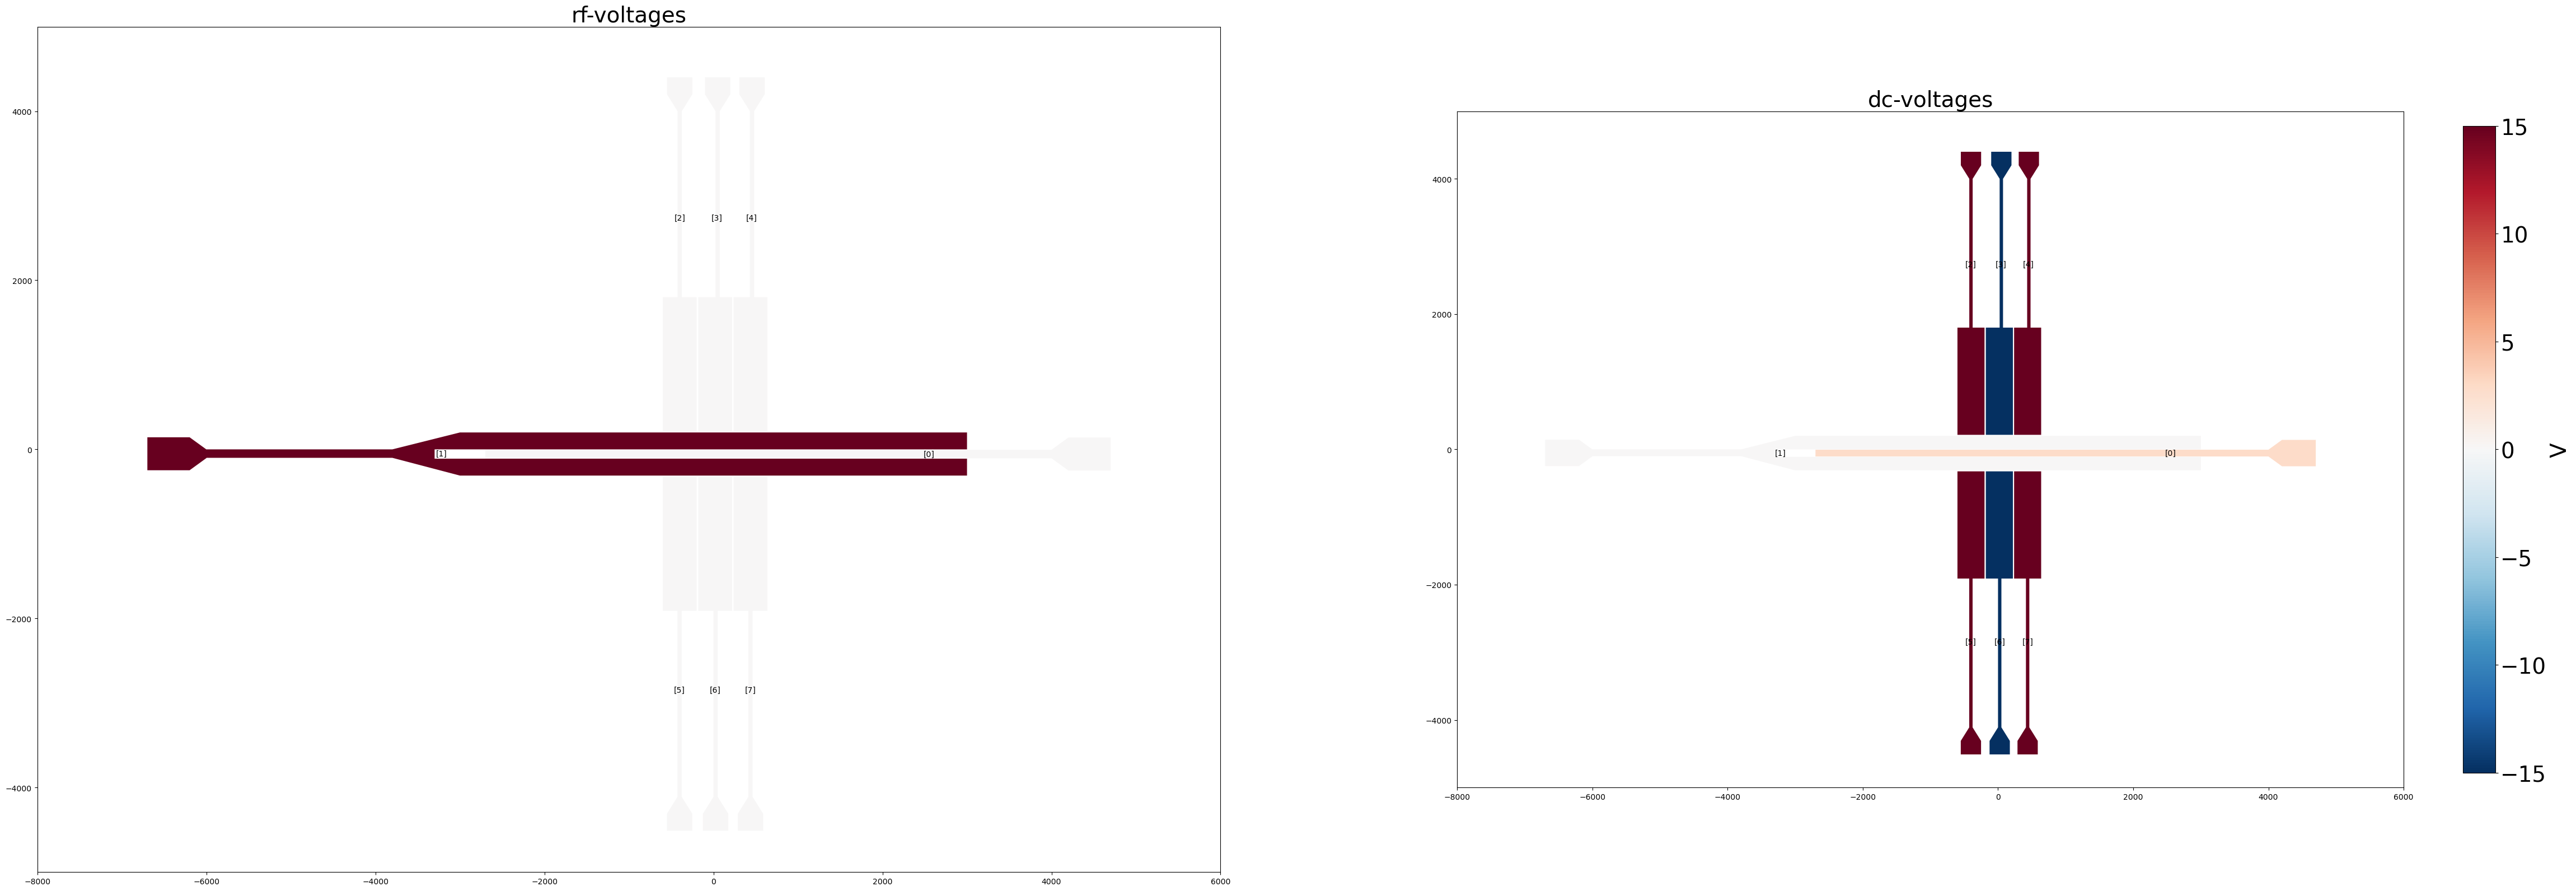

In [74]:
# Global definition of trap parameters. Used for all cells in this notebook
Vrf = 100. # RF peak voltage in V
M = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*30e6 # RF frequency in rad/s
# RF voltage in parametrized form so that the resulting potential equals the RF pseudopotential in eV
Urf = Vrf*np.sqrt(Z/M)/(2*L*Omega)

RF_electrodes = [full_electrode_list[1]]
DC_electrodes = [full_electrode_list[0]] + full_electrode_list[2:]

s.rfs = np.array([0, Urf, 0, 0, 0, 0, 0, 0])
s.dcs = 1*np.array([2.859, 0, 15, -15, 15, 15, -15, 15])
rf_set = [Vrf]
dc_set = [2.859, 15, -15, 15, 15, -15, 15]
omegas = [Omega]

fig, ax = plt.subplots(1, 2, figsize=(60, 30))
s.plot_voltages(ax[0], u=s.rfs)
s.plot_voltages(ax[1], u=s.dcs)
ax[0].set_title("rf-voltages", fontsize = 28)
# ax[0] addresses the first plot in the subplots - set_title gives this plot a title
ax[1].set_title("dc-voltages", fontsize = 28)
for axi in ax.flat:
    axi.set_aspect("equal")
    axi.set_xlim(-8000, 6000)
    axi.set_ylim(-5000, 5000)
cmap = plt.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=np.min(s.dcs), vmax=np.max(s.dcs))

cb = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap=cmap),ax=axi,orientation = 'vertical', shrink =0.5, pad = 0.05)

cb.ax.tick_params(labelsize=28)
cb.set_label('V', fontsize = 28)

## Potential characterization

The following block calculates the potential minimum of Ca ions in the trap, utilizing the *electrode* package functions.

In [75]:
with s.with_voltages(dcs = np.zeros(8), rfs = None):
    x0 = s.minimum([0,29.8,79], axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")

x1 = s.minimum(x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
print('The minimum is (%.3g, %.3g, %.3g)' % (x1[0], x1[1], x1[2]))
print('Distance from RF-minimum: (%.3g, %.3g, %.3g)' % (x1[0] - x0[0], x1[1] - x0[1], x1[2] - x0[2]))
# Get trap frequencies
try:
    curv_z, mod_dir=s.modes(x1,sorted=False)
    omega_sec=np.sqrt(Z*curv_z/M)/(L*2*np.pi) * 1e-6
    print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("In directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    e1 = np.array([0,0,1])
    alp = np.arccos(np.inner(mod_dir[2],e1))
    print('Angle of secular modes rotation alpha:', alp)
except:
    print("Secular frequencies not found")

The minimum is (-474, -55, 118)
Distance from RF-minimum: (-474, -8.73e-06, -4.94e-05)
Secular frequencies: (0.9305, 2.84, 3.479) MHz
In directions
a: [ 9.99955350e-01  9.44972140e-03 -9.26034959e-08] 
b: [-1.14997017e-07  2.36921127e-06 -1.00000000e+00] 
c: [-9.44972140e-03  9.99955350e-01  2.37019217e-06]
Angle of secular modes rotation alpha: 1.570793956602725


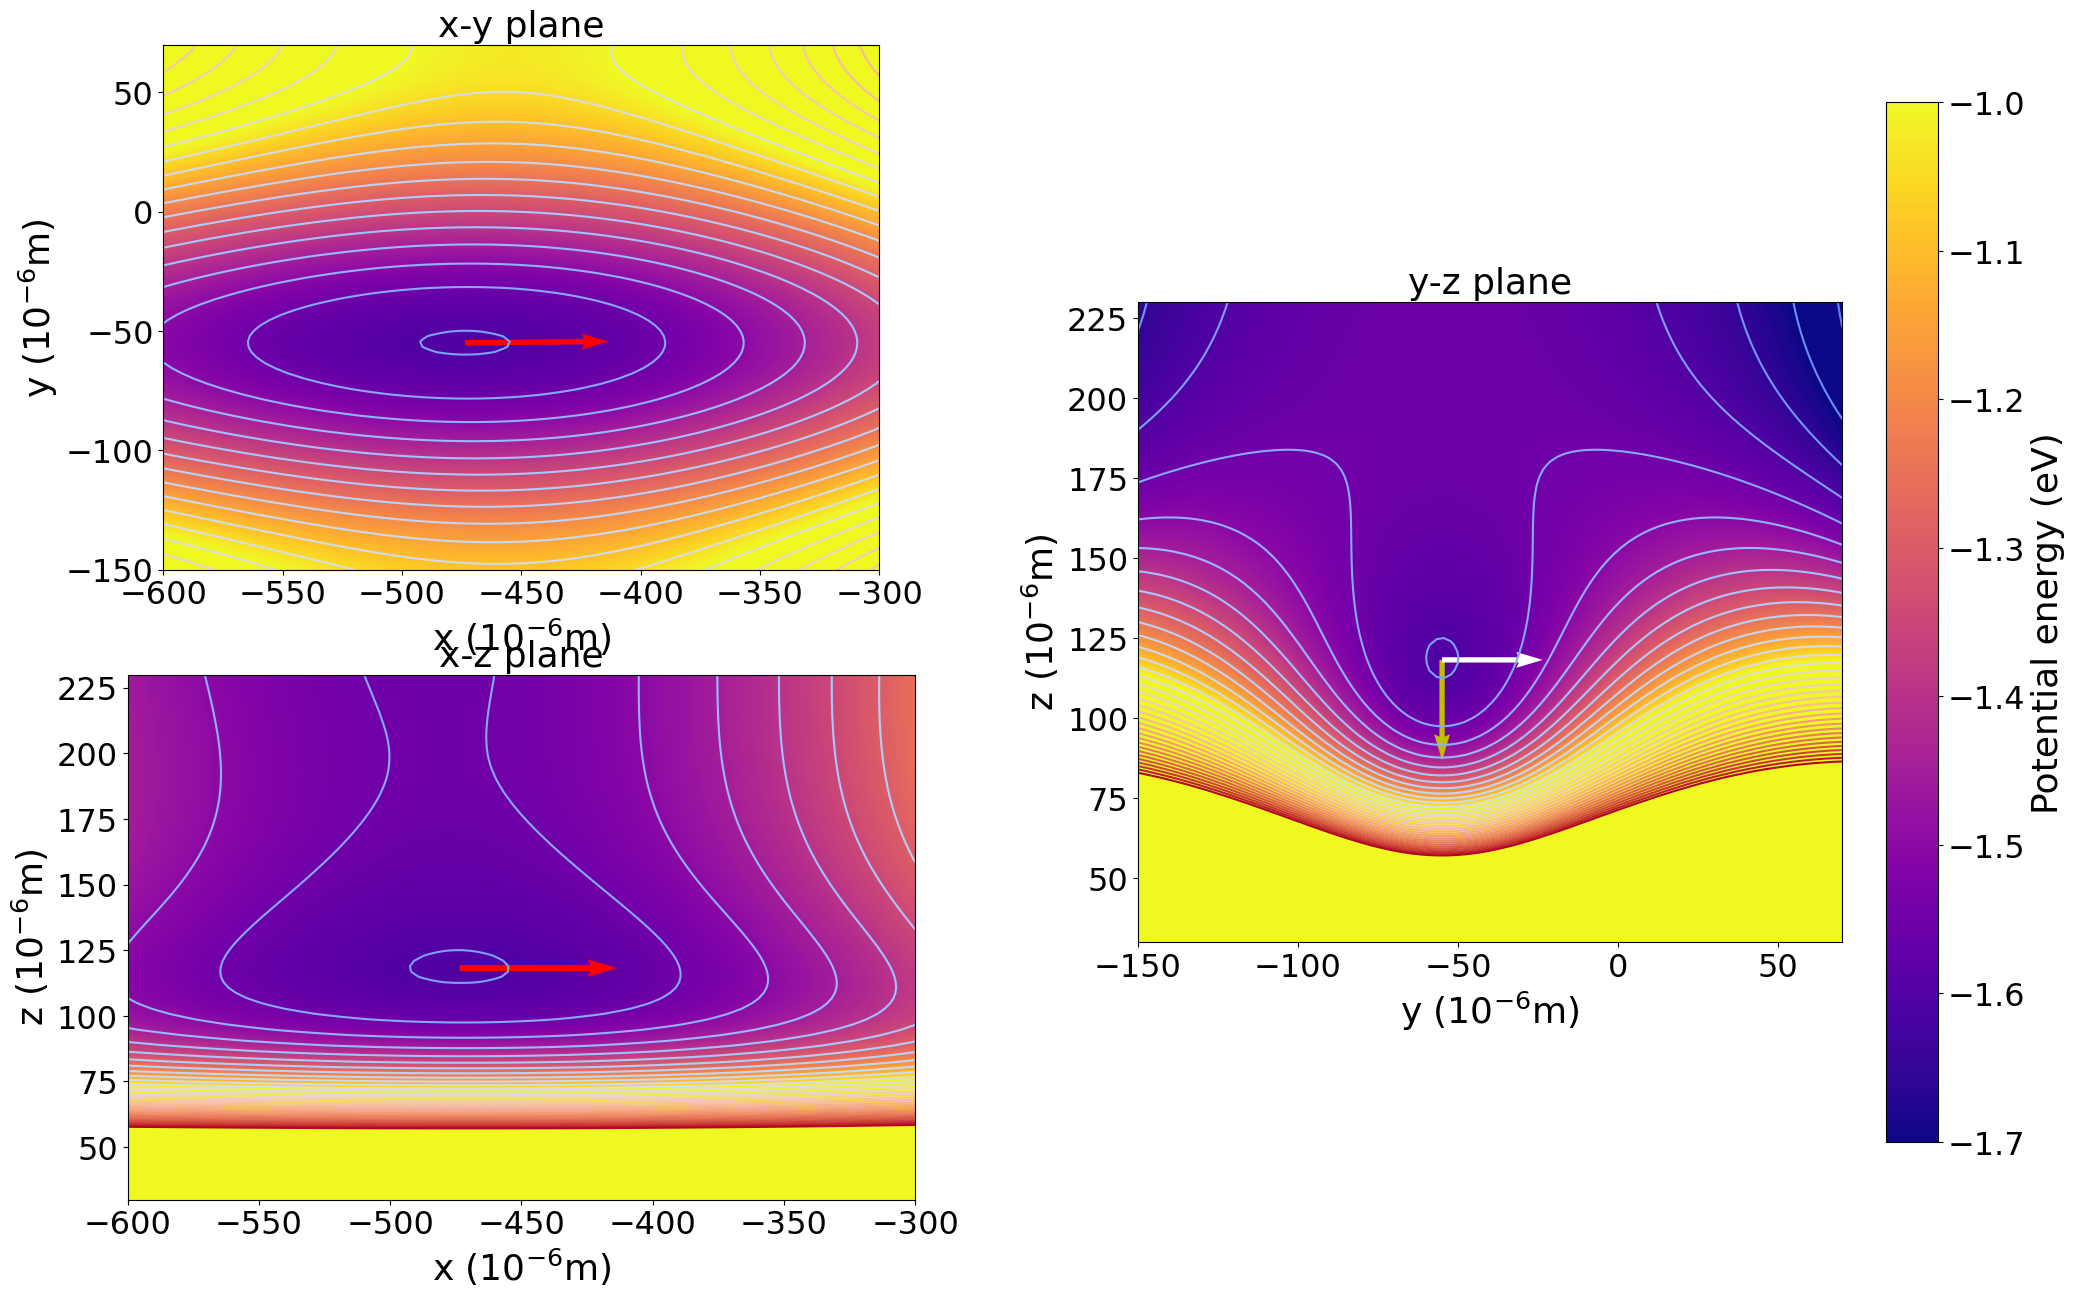

In [76]:

n=100 # resolution of meshgrid = resolution of 2D plots
xmin, xmax = -600, -300 #set the plot ranges
ymin, ymax = -150, 70
zmin, zmax = 30, 230
x_cut, y_cut, z_cut = x1[0], x1[1], x1[2]# position of the yz-, xz-, xy- crossection
v = np.arange(-2, 0, 0.05)# set the range for contour lines (range in eV)
v_min, v_max = -1.7, -1 # set the range for colour map (range in eV)
fs = 26 #set the fontsize
ls = 23 #set the labelsize
fig = plt.figure()
fig.set_size_inches(25,15)

# x-y cross section
ax1 = plt.subplot2grid((2,2), (0,0))
ax1.set_title("x-y plane" ,fontsize=fs)
ax1.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
ax1.set_ylabel('y ($10^{-6}$m)',fontsize=fs)
ax1.tick_params(axis='x', labelsize=ls)
ax1.tick_params(axis='y', labelsize=ls)
xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+1]
pot = shaped(s.potential)(xyz)
x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
CS=ax1.contour(x, y, p, v, cmap=plt.cm.coolwarm)
im = ax1.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,ymin,ymax))
im.set_interpolation('bilinear')

# x-z cross section
ax2 = plt.subplot2grid((2,2), (1,0))
ax2.set_title("x-z plane" ,fontsize=fs)
ax2.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
ax2.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
ax2.tick_params(axis='x', labelsize=ls)
ax2.tick_params(axis='y', labelsize=ls)
xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+1, zmin:zmax:1j*n]
pot = shaped(s.potential)(xyz)
x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
CS=ax2.contour(x, z, p, v, cmap=plt.cm.coolwarm)
im = ax2.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,zmin,zmax))
im.set_interpolation('bilinear')

# y-z cross section
ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)
ax3.set_title("y-z plane" ,fontsize=fs)
ax3.set_xlabel('y ($10^{-6}$m)',fontsize=fs)
ax3.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
ax3.tick_params(axis='x', labelsize=ls)
ax3.tick_params(axis='y', labelsize=ls)
xyz = np.mgrid[x_cut:x_cut+1, ymin:ymax:1j*n, zmin:zmax:1j*n]
pot = shaped(s.potential)(xyz)
x, z, p = (_.reshape(n, n) for _ in (xyz[1], xyz[2], pot))
CS=ax3.contour(x, z, p, v, cmap=plt.cm.coolwarm)
im = ax3.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(ymin,ymax,zmin,zmax))
im.set_interpolation('bilinear') 

# add colorbar
cb = fig.colorbar(im, ax=ax3, shrink=0.9)
cb.ax.tick_params(labelsize=ls)
cb.set_label('Potential energy (eV)', fontsize = fs)

#add secular frequencies
#change color and scale (the fewer, the longer the arrow)
ax1.quiver(*[[x1[0]],[x1[1]]], mod_dir[0][0], mod_dir[0][1], color=['r'], scale = 5)
ax2.quiver(*[[x1[0]],[x1[2]]], mod_dir[0][0], mod_dir[0][2], color=['r'], scale = 5)
ax3.quiver(*[[x1[1]],[x1[2]]], mod_dir[1][1], mod_dir[1][2], color=['y'], scale = 7)
ax3.quiver(*[[x1[1]],[x1[2]]], mod_dir[2][1], mod_dir[2][2], color=['w'], scale = 7)

## Polygon trap simulation

The following block demonstrates simulation of ion dynamics, performed with generalized *polygon_trap()* function, utilizing *pyLion* package for LAMMPS simulation execution. The *polygon_trap()* function is able to initialize planar ion traps of arbitrary shape, represented by polygonal electrodes.

In [77]:
# simulation of ion crystal
ion_number = 4
x0 = x1*1e-6

#insert your path to this file here
name = Path('simulation_from_gds.ipynb').stem

sim = pl.Simulation(name)

#ion declaration
Caions = {'mass': 40, 'charge': 1}

#placing ions
positions = sn.ioncloud_min(x0, ion_number, 4e-6)
sim.append(pl.placeions(Caions, positions))

#polygon trap initialization
sim.append(sn.polygon_trap(omegas, rf_set, dc_set, RF_electrodes, DC_electrodes))

#temperature and cooling
sim.append(pl.thermalvelocities(2, False))
sim.append(pl.langevinbath(0, 5e-6))

#file with simulation information
sim.append(pl.dump('positions_gds.txt', variables=['x', 'y', 'z'], steps=10))
sim.append(pl.evolve(1e5))
try:
    sim.execute()
except:
    pass

Reducing timestep to 2.652582384864922e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  4 settings made for charge
4 atoms in group 1
4 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 2.65258e-10
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 | 4.78 Mbytes
Step 

C:\Users\User_A\anaconda3\lib\site-packages\pylion-0.5.2-py3.9.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


## Ion crystal

The following block demonstrates ion coordinates evolution under cooling during the simulation. Additionally, the formed ion crystal is shown.

Final positions of ions:
 [[-4.80065e-04 -5.51622e-05  1.18229e-04]
 [-4.75681e-04 -5.50605e-05  1.18513e-04]
 [-4.71538e-04 -5.50573e-05  1.17995e-04]
 [-4.66941e-04 -5.49123e-05  1.17976e-04]]


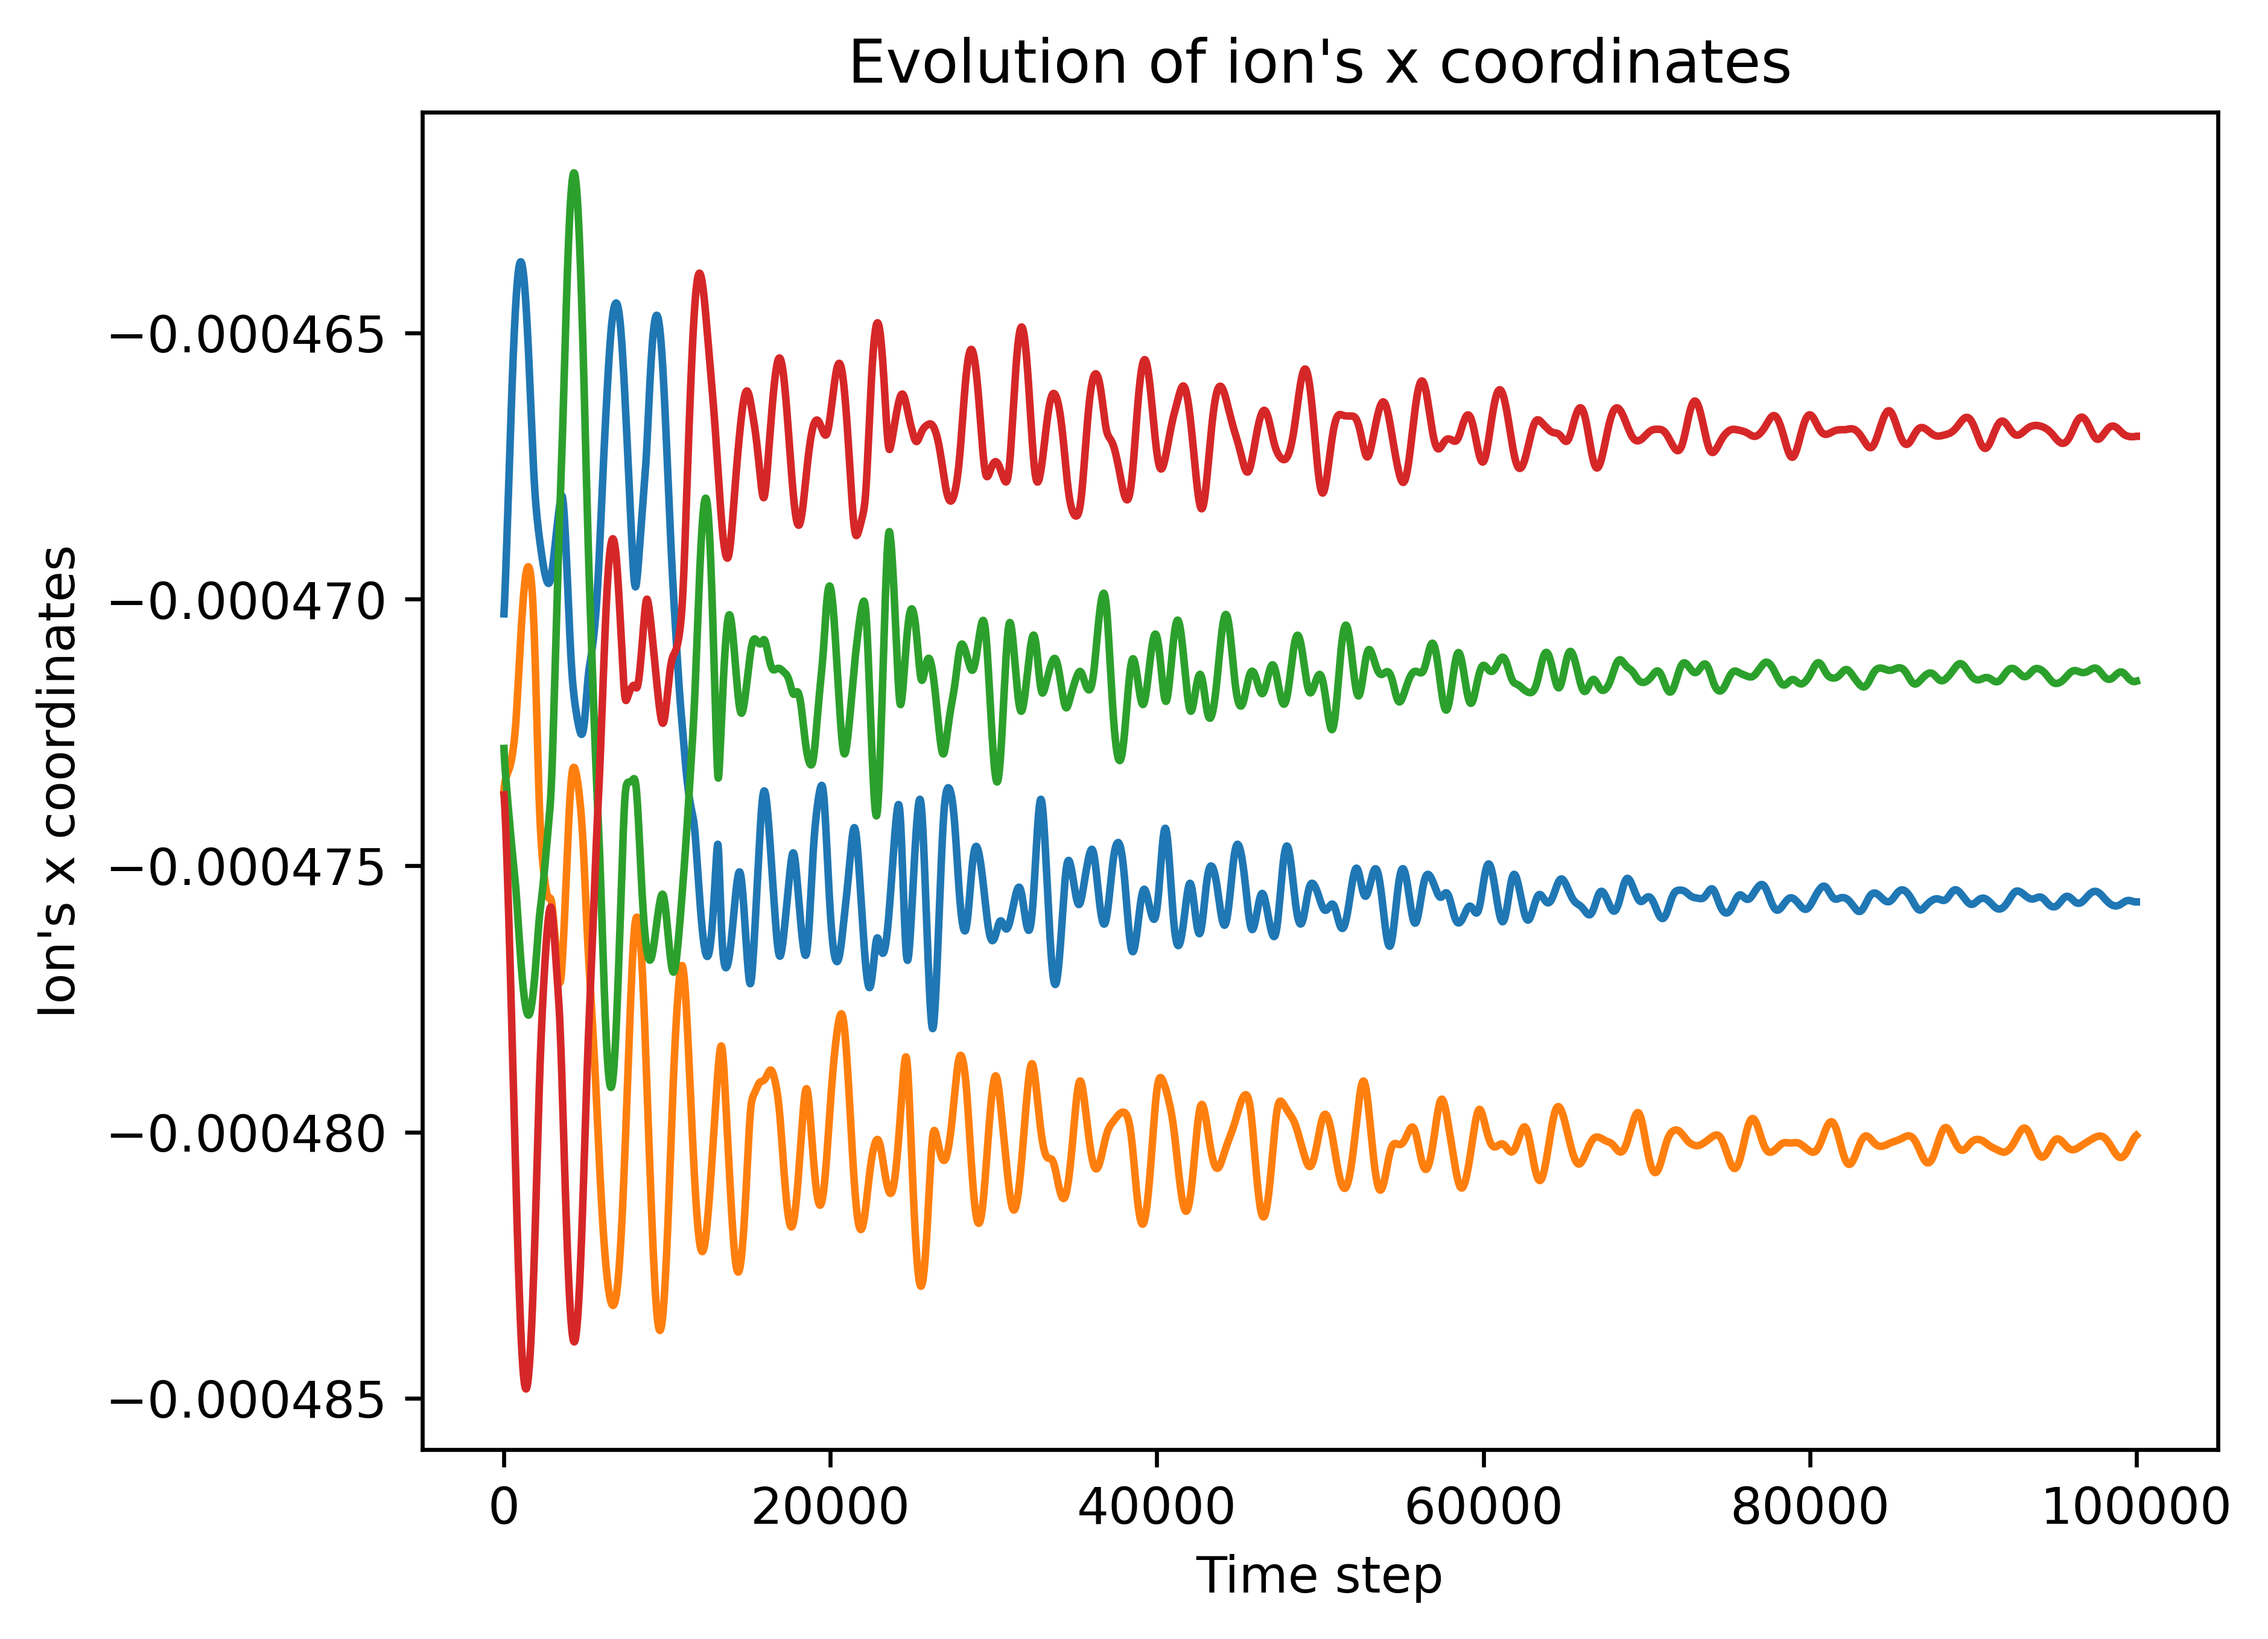

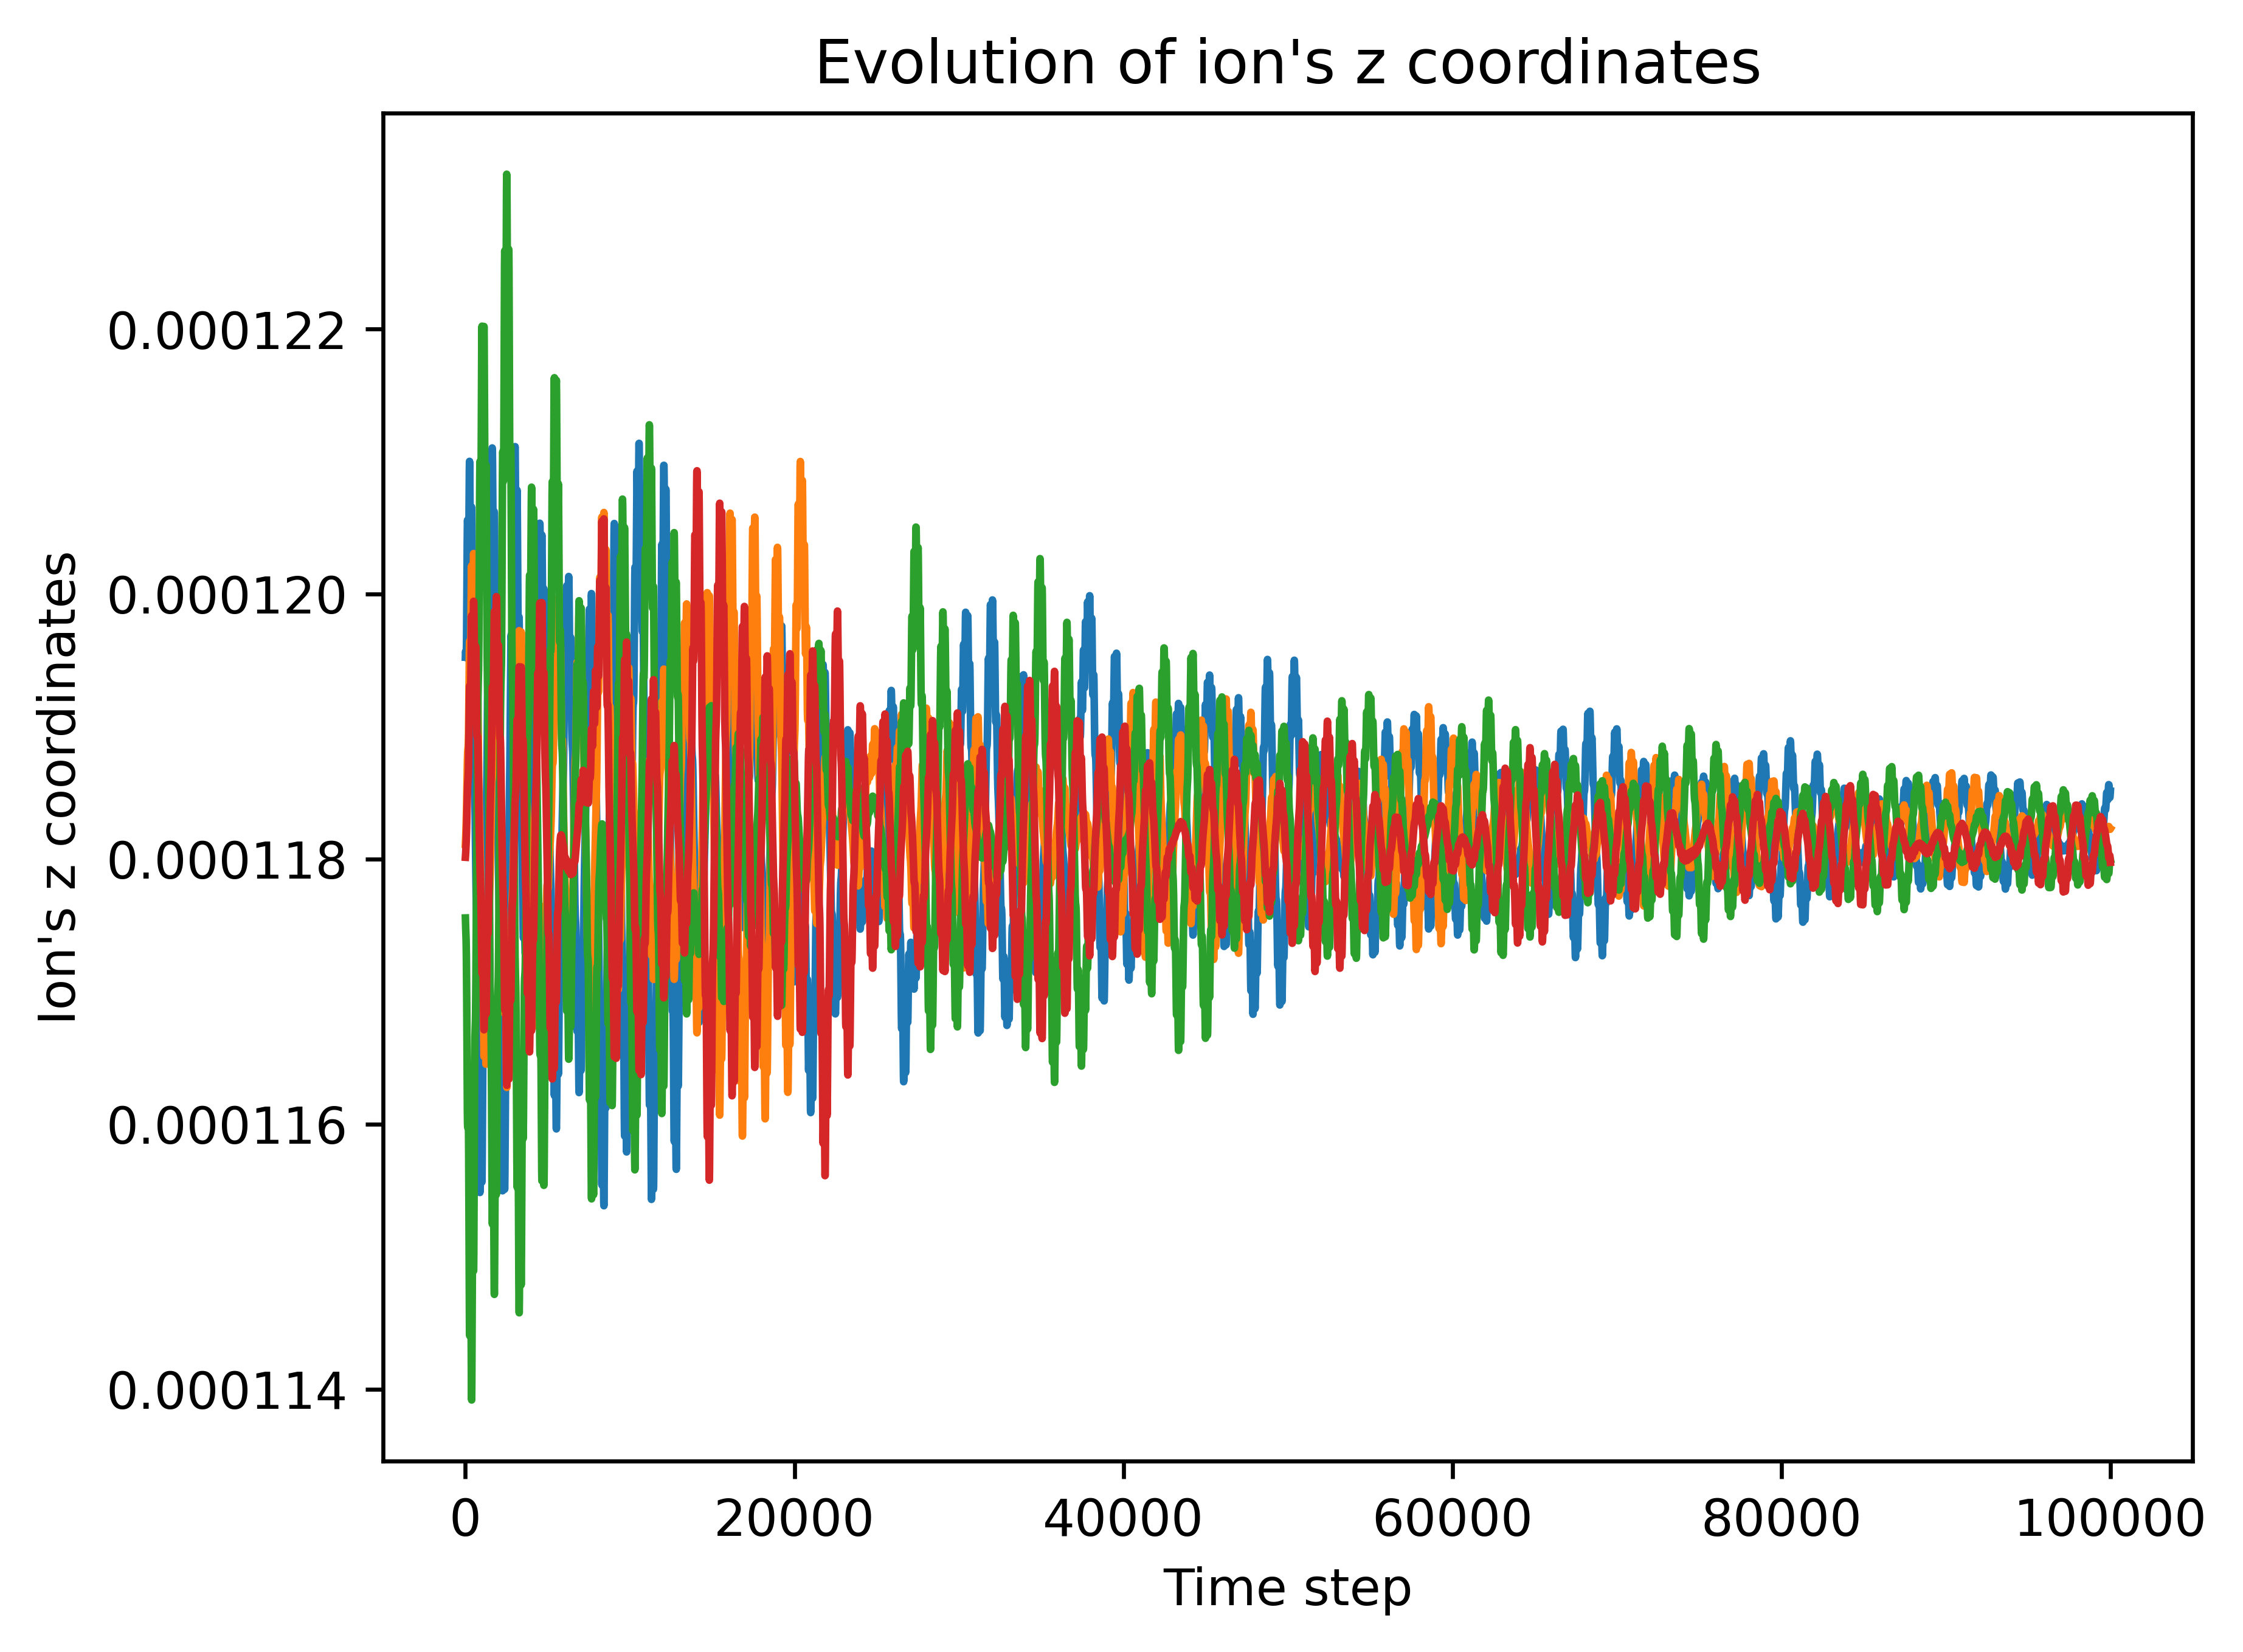

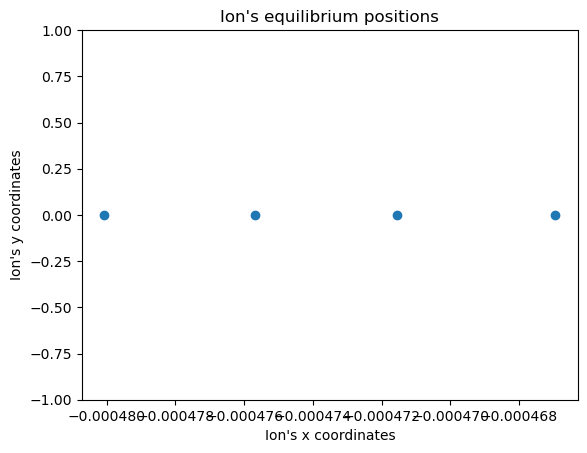

In [79]:
_, data = pl.readdump('positions_gds.txt')

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

ion_positions = np.zeros([ion_number, 3])
sort = np.argsort(final_x)

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

print('Final positions of ions:\n', ion_positions)


# Plot of ion crystal evolution
plt.figure(dpi = 600)
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

plt.figure(dpi = 600)
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 2])
plt.title('Evolution of ion\'s z coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s z coordinates')
plt.show()

# Plot of the final ion crystal configuration
plt.figure()
plt.scatter(data[-1, :, 0], data[-1, :, 1])
plt.title('Ion\'s equilibrium positions')
plt.xlabel('Ion\'s x coordinates')
plt.ylabel('Ion\'s y coordinates')
plt.ylim([-max(1, 1.2 * np.max(np.abs(data[-1, :, 1]))), max(1, 1.2 * np.max(np.abs(data[-1, :, 1])))])
plt.show()
